## T Cell Annotation <a class="tocSkip">

Loads integrated T cell anndata with pre-specified clustering and marker gene dictionary, and annotates cells.

Author: Kevin Hoffer-Hawlik

## Setup

In [1]:
import warnings
warnings.simplefilter(action='ignore',)
warnings.simplefilter(action='ignore',)
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=ResourceWarning)

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import scipy.stats
import scib
import pickle
import seaborn as sns

Global seed set to 0
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Load Data

In [ ]:
tcell_filepath = 'tcells_scvi_clusters_030823.h5ad'
marker_genes_filepath = 'marker_genes_dict_030823.pickle'

tcells = sc.read_h5ad(tcell_filepath)

In [6]:
# load marker genes dictionary
with open(marker_genes_filepath, 'rb') as handle:
    marker_genes = pickle.load(handle)
marker_genes.keys()

dict_keys(['lineage_markers', 'naive_markers', 'memory_markers', 'exhaustion_markers', 'activation_markers', 'effector_cytokines', 'transcription_factors', 'self-renewal/memory markers', 'NK/gd T cell genes', 'Th17', 'Treg', 'Tfh', 'Th22', 'Th9', 'Pro_inflammatory', 'Cytolytics_effector_pathway', 'CD8_T_cell_activation', 'Type_I_interferon_response', 'Type_II_interferon_response', 'Exhaustion/Terminal_differentiation', 'CD8_deletional_tolerance', 'CD8_TIL_dysfunction', 'G2/M', 'G1/S', 'Glycogen_metabolism', 'Hypoxia/HIF_regulated', 'CD4_T _cell_anergy', 'CD8_peripheral_tolerance', 'Anti-inflammatory', 'TCA_cycle', 'Pentose_phosphate_pathway', 'Senescence', 'Adenosine_pathway', 'Glucose_deprivation', 'T_cell_co-inhibitory_receptors', 'Effector_cell_cytotoxicity', 'Terminal_exhaustion', 'Precursor_exhaustion', 'T_naive', 'T_stem_central_memory', 'T_central_memory', 'T_effector_memory', 'T_terminal_effector'])

## First round of cell annotation

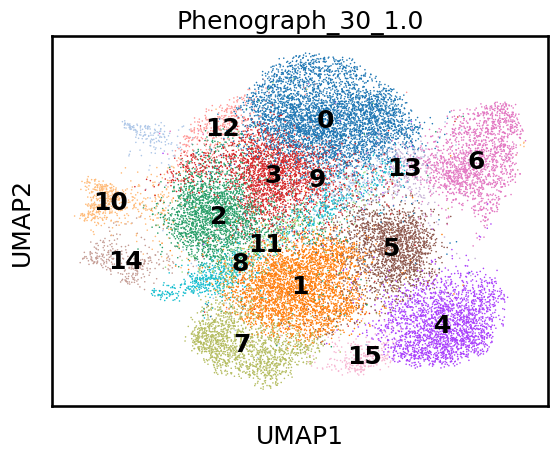

In [36]:
CLUSTERS = 'Phenograph_30_1.0'
sc.pl.umap(tcells, color = CLUSTERS, legend_loc='on data', )

In [ ]:
# assign cell types based on clusters and marker genes from previous notebook
cluster_names = {
    0: "CD8+ T", 
    1: "CD4+ T", 
    2: "CD8+ T", 
    3: "CD8+ T", 
    4: "Treg", 
    5: "CD4+ T", 
    6: "cycling", 
    7: "TBD", # need to recluster
    8: "CD8+ T", # previously stuck between CD4+ or CD8+, but CD8 vs CD4 scatterplots indicate CD8+ 
    9: "myeloid contam",  # remove for downstream analysis
    10: "NK_1", 
    11: "CD8+ T",  # previously, stuck between CD4+ or CD8+, but CD8 vs. CD4 scatterplots indicate CD8+
    12: "CD8+ T", 
    13: "CD8+ T", 
    14: "NK_2", 
    15: "naive Treg", # later changed to Treg
}
tcells.obs["cell_type_coarse_khh"] = tcells.obs[CLUSTERS].map(cluster_names)

## Sub-annotation

In [38]:
tcells_round2 = tcells[tcells.obs[CLUSTERS] == 7,:]
tcells_round2.shape

(1641, 8170)

<AxesSubplot: xlabel='CD4', ylabel='CD8B'>

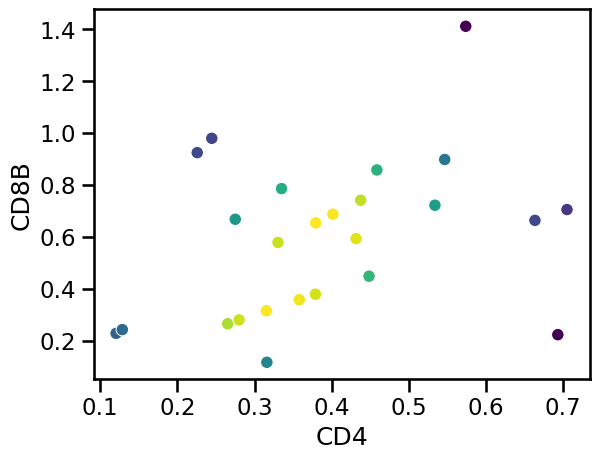

In [49]:
df = tcells_round2[:,['CD4','CD8B']].to_df()
df = df.loc[(df['CD4'] != 0) & (df['CD8B'] !=0),:] # fix this so it stops filtering out the 0s in the sides
values = np.vstack([df['CD4'], df['CD8B']])
kernel = scipy.stats.gaussian_kde(values)(values)
sns.scatterplot(data = df, x='CD4', y='CD8B', c=kernel)

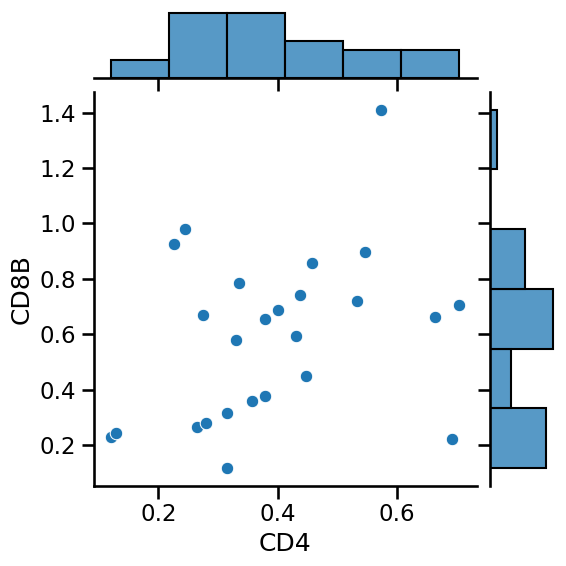

In [50]:
sns.jointplot(x = 'CD4', y='CD8B', data = df, kind = 'scatter')

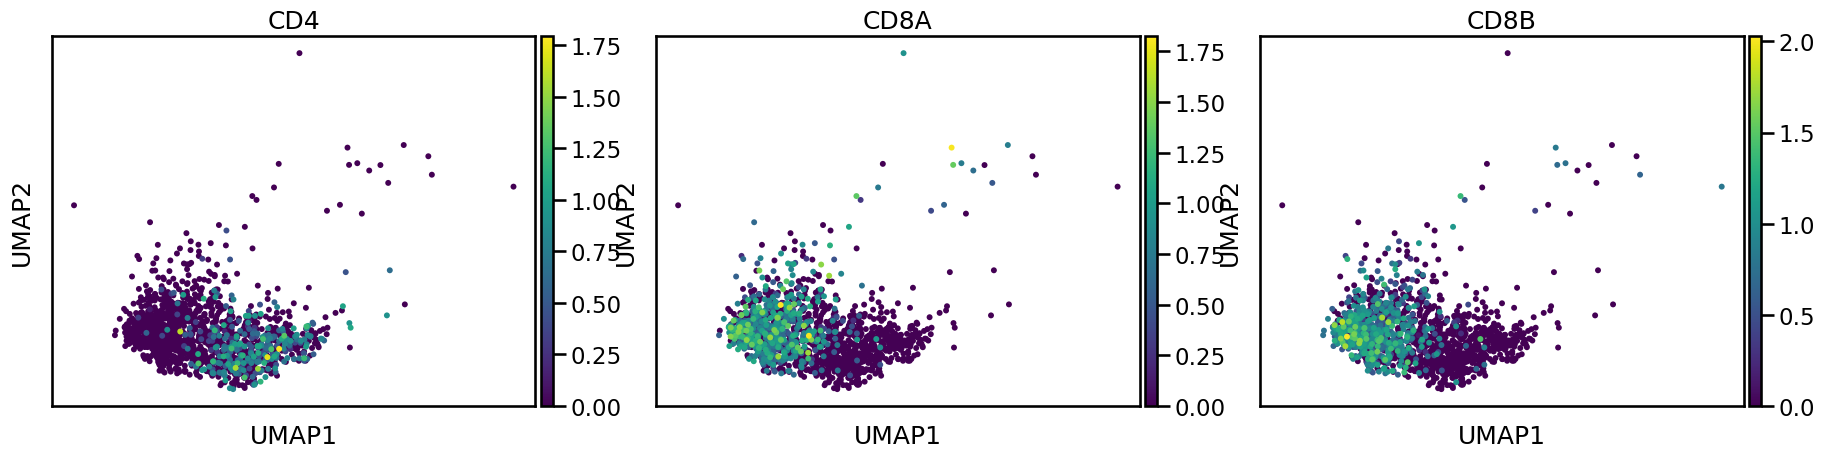

In [51]:
sc.pl.umap(tcells_round2, color=['CD4', 'CD8A', 'CD8B'])

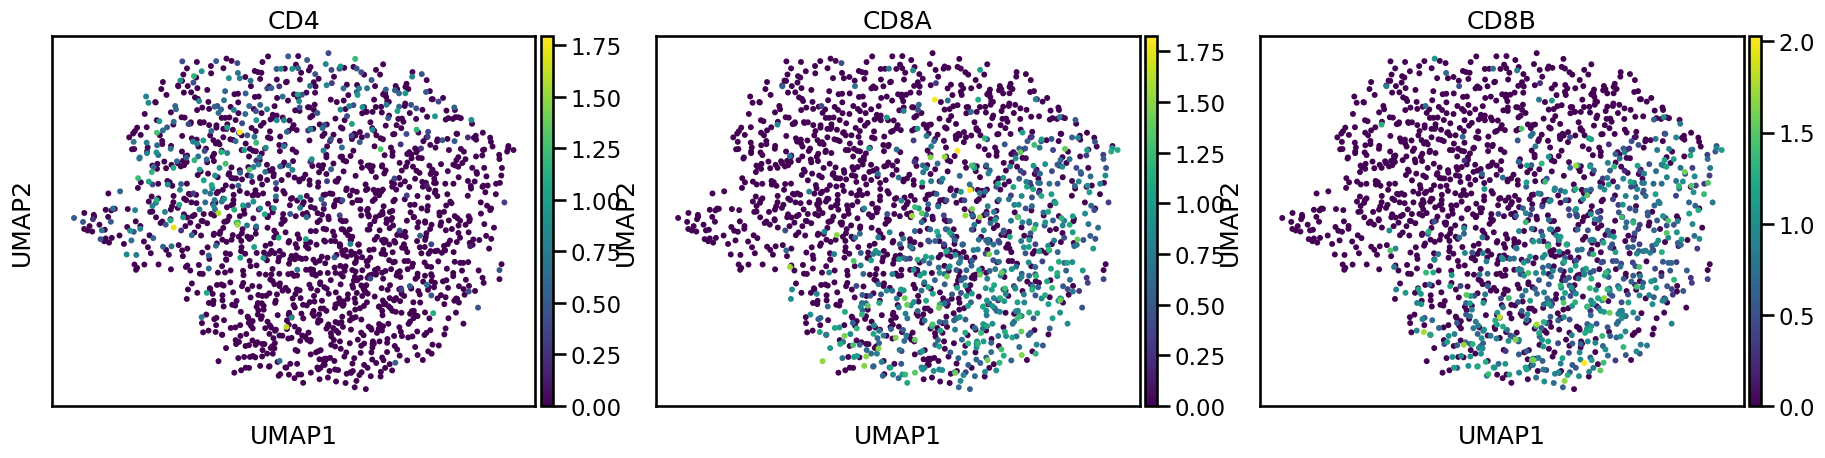

In [52]:
# calculate new neighborhood graph and UMAP dim reduction
sc.pp.neighbors(tcells_round2, use_rep="X_scVI", n_neighbors = 20)
sc.tl.umap(tcells_round2)
sc.pl.umap(tcells_round2, color=['CD4', 'CD8A', 'CD8B'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1278486251831055 seconds
Jaccard graph constructed in 2.7321815490722656 seconds
Wrote graph to binary file in 0.01882791519165039 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.498047
After 3 runs, maximum modularity is Q = 0.499577
After 14 runs, maximum modularity is Q = 0.504363
Louvain completed 34 runs in 0.6665499210357666 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.0410966873168945 seconds


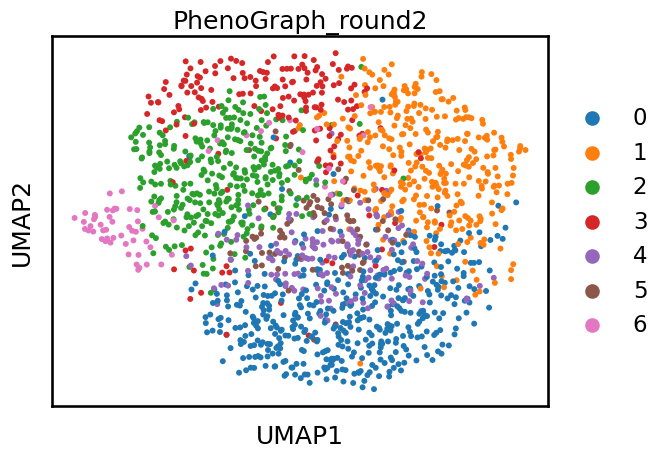

In [53]:
communities, graph, Q = sc.external.tl.phenograph(tcells_round2.obsm['X_scVI'], k = 30, resolution_parameter = 1.0)
tcells_round2.obs['PhenoGraph_round2'] = pd.Categorical(communities)
tcells_round2.uns['PhenoGraph_round2_Q'] = Q
sc.pl.umap(tcells_round2, color = 'PhenoGraph_round2')

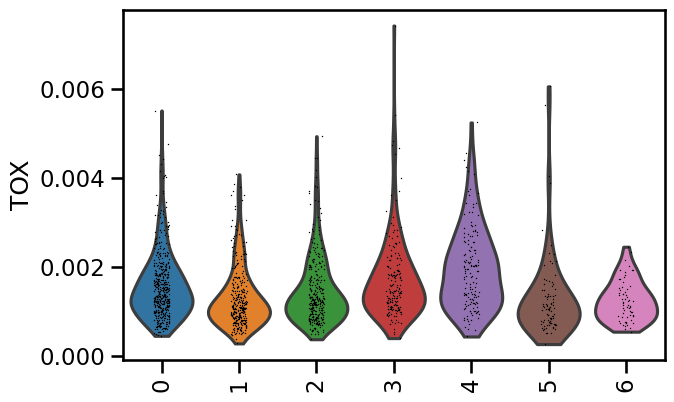

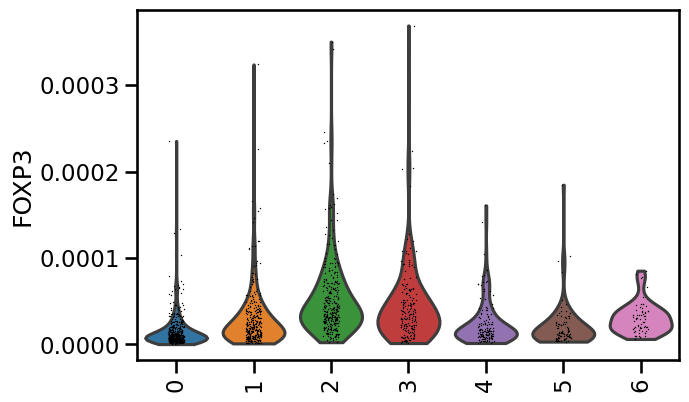

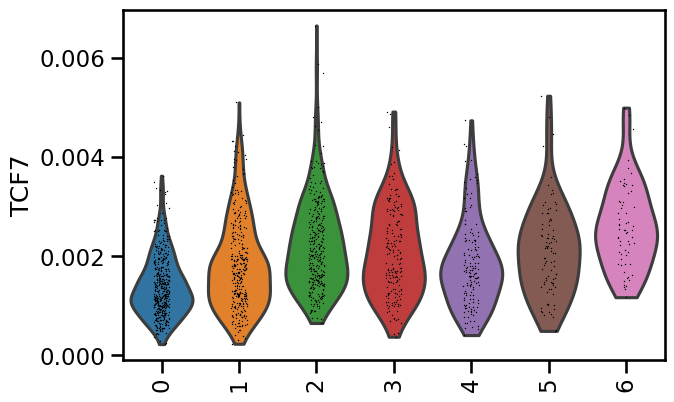

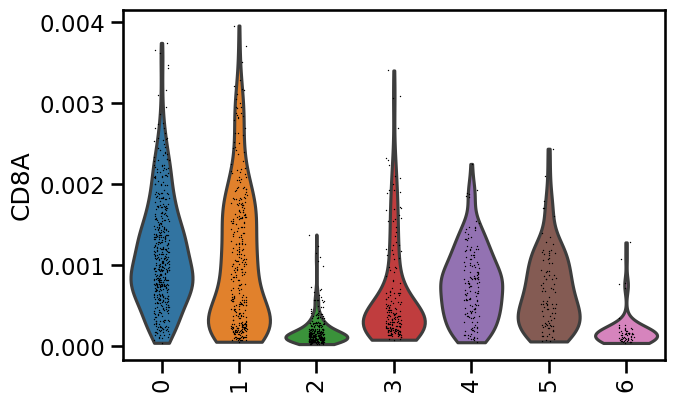

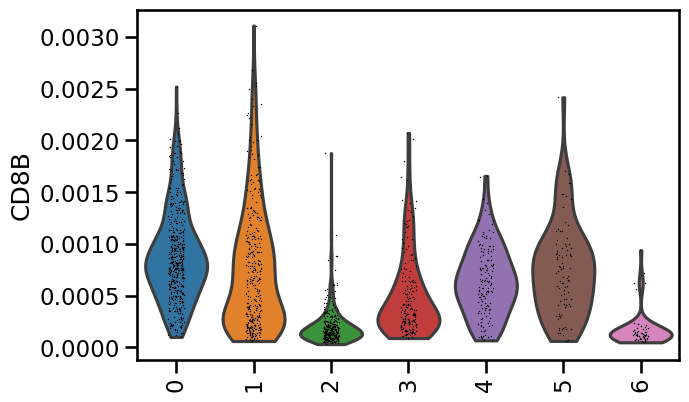

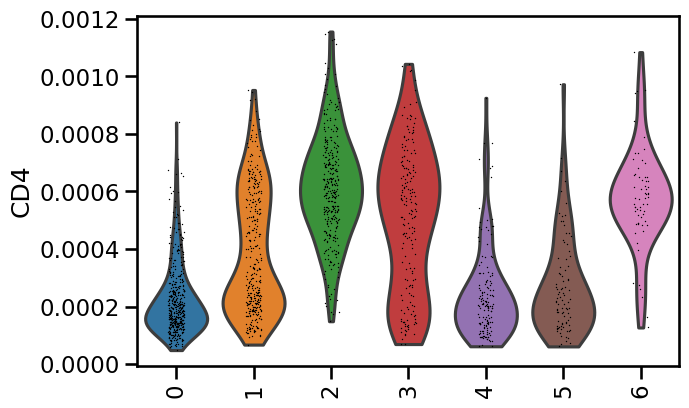

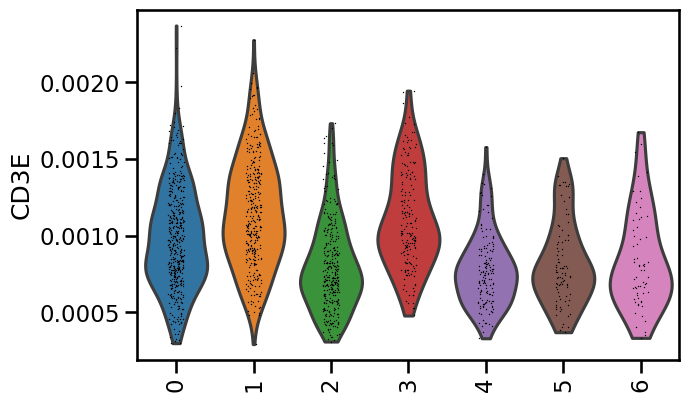

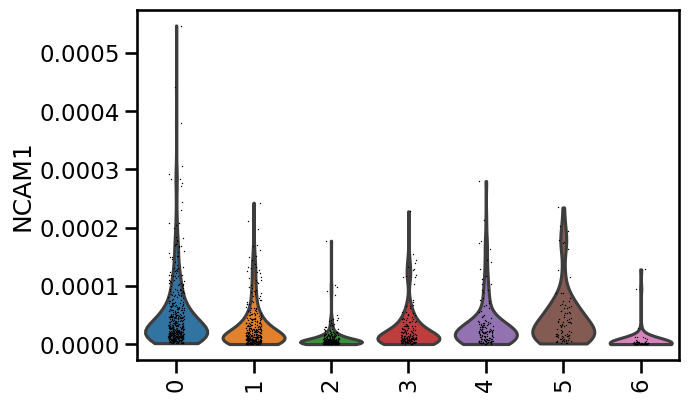

In [54]:
# violin plots of specific genes
violin_keys = ["TOX", "FOXP3", "TCF7", "CD8A", "CD8B", "CD4", "CD3E", "NCAM1"]
for key in violin_keys:
    sc.pl.violin(tcells_round2, layer = "scvi_normalized", use_raw = False, keys=key, 
                 groupby='PhenoGraph_round2', rotation=90)

In [55]:
tcells_round2.uns["log1p"]["base"] = None # needed if loading anndata (r/w error in scanpy)

# generate DEG tables using unintegrated, logarithmized counts and scanpy methods
sc.tl.rank_genes_groups(tcells_round2, 
                        groupby='PhenoGraph_round2',
                        # layer = "scvi_normalized",
                        use_raw = True,
                        method='t-test', 
                        key_added = "t-test_r2")
deg_df = sc.get.rank_genes_groups_df(tcells_round2, group=None, key='t-test_r2').sort_values(["scores"],ascending=False)

In [56]:
deg_df = deg_df.loc[(deg_df.pvals_adj < 0.05) & (deg_df.logfoldchanges > 1.0),:]
deg_df.loc[deg_df.group=='3',:]#.names.values # IL2RA suggests Treg; directional FOXP3

group       names    scores  logfoldchanges         pvals     pvals_adj
107373     3        AFF3  6.683846        1.605958  2.030039e-10  3.824058e-07
107374     3       PLCL1  6.678674        1.122543  1.840846e-10  3.824058e-07
107376     3  AL589693.1  6.108160        1.633080  4.847226e-09  5.102561e-06
107377     3         TOX  5.875358        1.635702  1.631440e-08  1.390259e-05
107383     3        RPL4  5.021080        1.002024  1.055394e-06  3.777361e-04
107386     3        CD38  4.856971        1.516203  2.366174e-06  7.170072e-04
107393     3      CD40LG  4.649847        1.573138  5.893133e-06  1.499277e-03
107395     3       RPL15  4.418643        1.117986  1.578804e-05  3.174549e-03
107397     3        SDK1  4.287861        1.980741  2.793606e-05  4.949799e-03
107398     3        SCAI  4.209716        1.011531  3.745171e-05  6.293118e-03
107400     3       DACH1  4.191962        5.411928  4.263775e-05  6.787599e-03
107401     3       IKZF2  4.191908        1.395188  4.076317e-05  6.601604e-03
107404     3       PDE7B  4.138638        1.807151  5.082698e-05  7.611500e-03
107405     3         CD4  4.137202        1.058990  4.991422e-05  7.506218e-03
107406     3       RPL29  4.122418        1.024343  5.323290e-05  7.872970e-03
107407     3        AFF2  4.115648        2.633253  5.691430e-05  8.247043e-03
107408     3       ITM2A  4.112957        1.473253  5.672847e-05  8.247043e-03
107411     3        CD74  4.070291        1.121610  6.622805e-05  9.223223e-03
107419     3  MIR181A1HG  3.901221        1.197999  1.289070e-04  1.527718e-02
107425     3       DDIT4  3.698476        1.124208  2.765429e-04  2.711712e-02
107430     3         CR2  3.615171        2.406480  3.821475e-04  3.360551e-02
107431     3       TENM1  3.605511        1.848243  3.932567e-04  3.408003e-02
107433     3      CACHD1  3.591745        1.293507  4.100490e-04  3.519440e-02
107436     3        EDAR  3.555860        1.024656  4.634710e-04  3.902550e-02
107437     3         FRY  3.532332        2.179453  5.121978e-04  4.156932e-02
107439     3        RPL9  3.530089        1.300813  5.102890e-04  4.150853e-02
107445     3         SET  3.460955        1.008459  6.495162e-04  4.814363e-02

In [57]:
# assign cell types based on clusters (round 2)
cluster_names_r2 = {
    0: "Naive CD8+ T", 
    1: "TBD", # need to recluster
    2: "Naive CD4+ T", 
    3: "Naive CD4+ T", # IL2RA suggests Tregs, but not statistically significant FOXP3
    4: "Naive CD8+ T", 
    5: "Naive CD8+ T", 
    6: "Naive CD4+ T", 
}
tcells_round2.obs["cell_type_r2_khh"] = tcells_round2.obs['PhenoGraph_round2'].map(cluster_names_r2)

In [58]:
tcells.obs['cell_type_khh'] = tcells.obs['cell_type_coarse_khh'] # add coarse labels first
tcells.obs['cell_type_r2_khh'] = tcells_round2.obs['cell_type_r2_khh'] # add labels from round 2
tcells.obs['cell_type_khh'] = np.where(tcells.obs['cell_type_khh'] == 'TBD', # transfer labels from round 2
                                       tcells.obs['cell_type_r2_khh'], tcells.obs['cell_type_khh'])

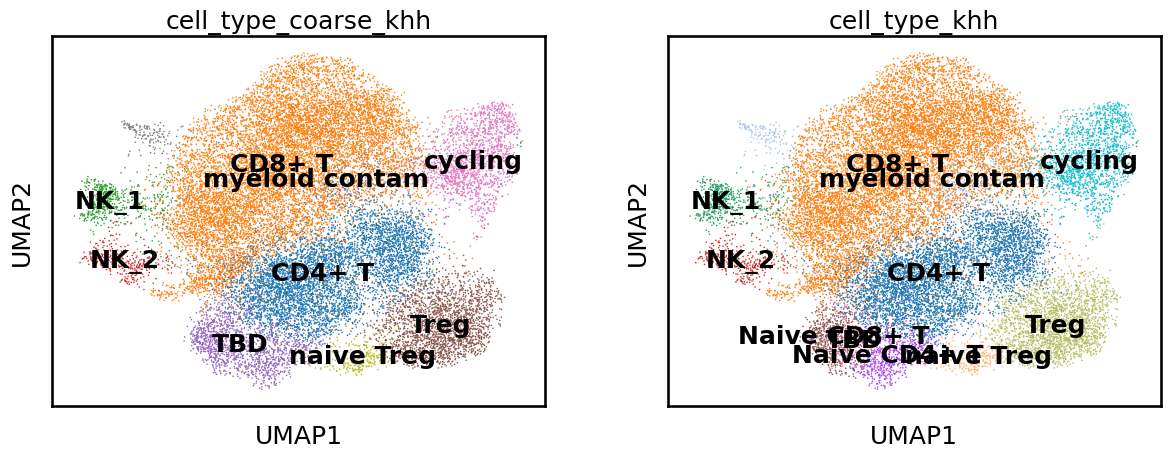

In [59]:
sc.pl.umap(tcells, color = ['cell_type_coarse_khh','cell_type_khh'], legend_loc = 'on data')

## Sub-annotation round 3

In [61]:
tcells_round3 = tcells[tcells.obs['cell_type_khh'] == "TBD",:]
tcells_round3.shape

(341, 8170)

<AxesSubplot: xlabel='CD4', ylabel='CD8B'>

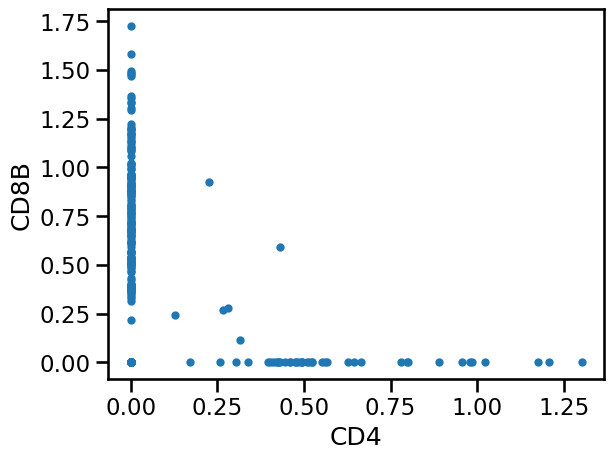

In [62]:
df = tcells_round3[:,['CD4','CD8B']].to_df()
df.plot.scatter(x='CD4', y='CD8B')

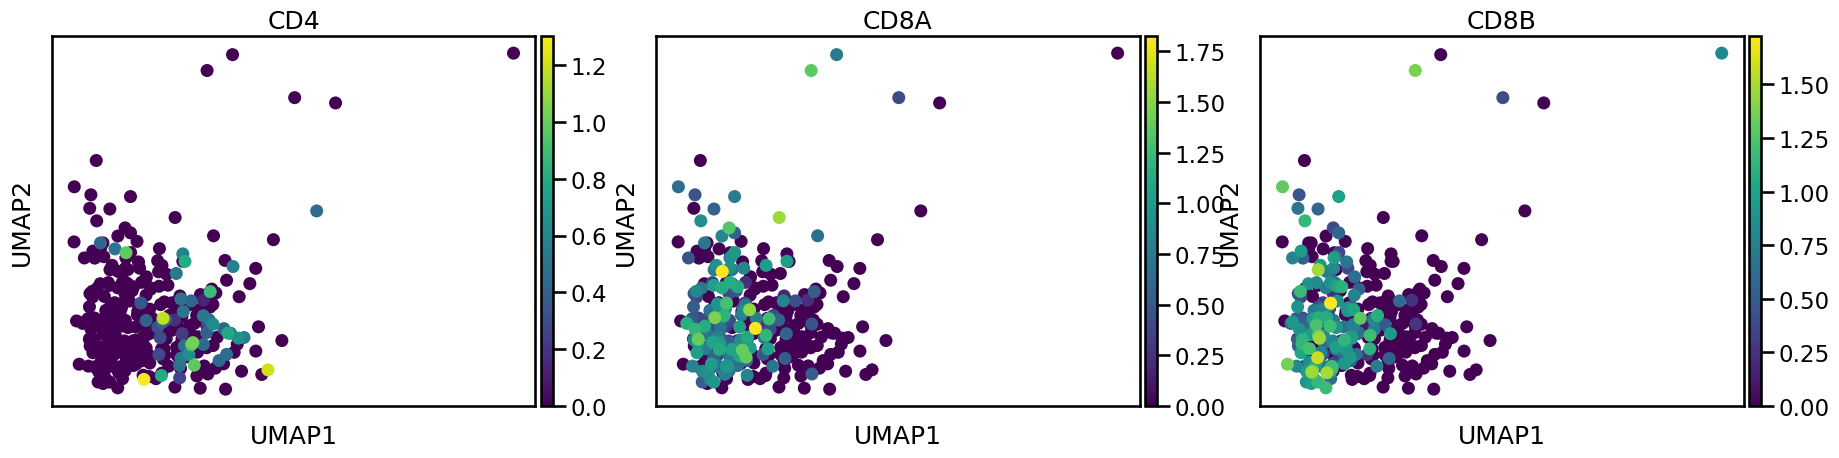

In [63]:
sc.pl.umap(tcells_round3, color=['CD4', 'CD8A', 'CD8B'])

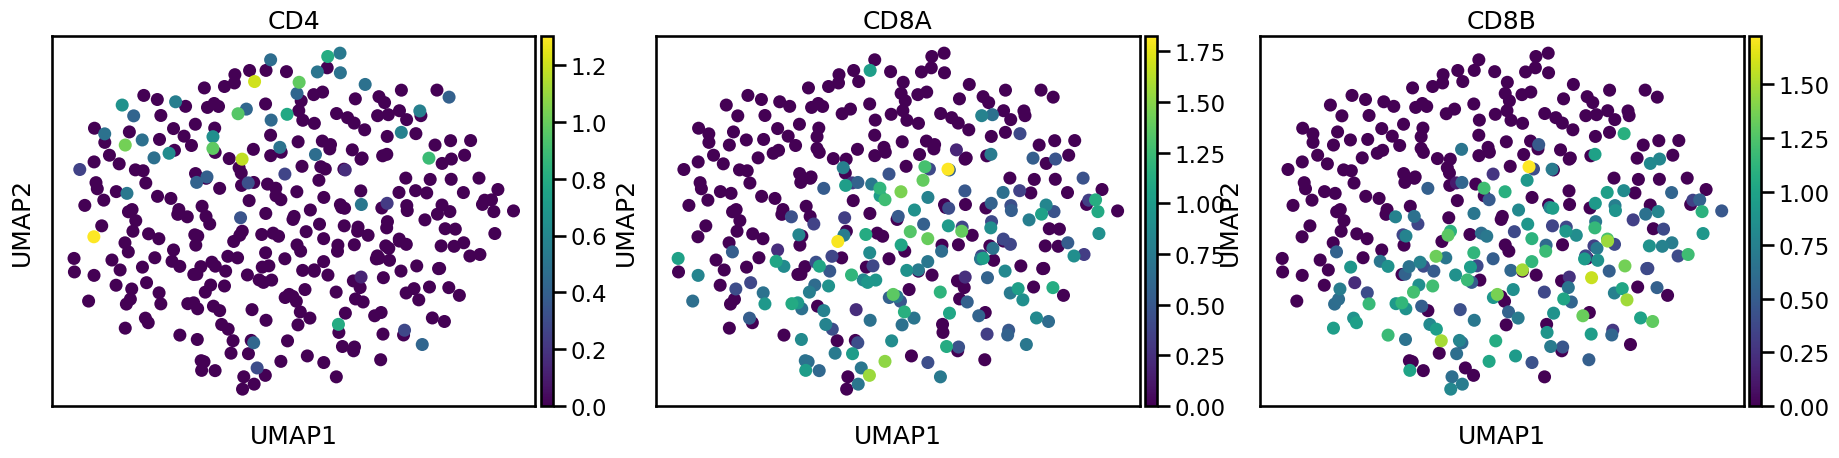

In [64]:
# calculate new neighborhood graph and UMAP dim reduction
sc.pp.neighbors(tcells_round3, use_rep="X_scVI", n_neighbors = 20)
sc.tl.umap(tcells_round3)
sc.pl.umap(tcells_round3, color=['CD4', 'CD8A', 'CD8B'])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.034546852111816406 seconds
Jaccard graph constructed in 2.672133207321167 seconds
Wrote graph to binary file in 0.004332304000854492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.379222
After 18 runs, maximum modularity is Q = 0.381484
Louvain completed 38 runs in 0.16690921783447266 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.475542068481445 seconds


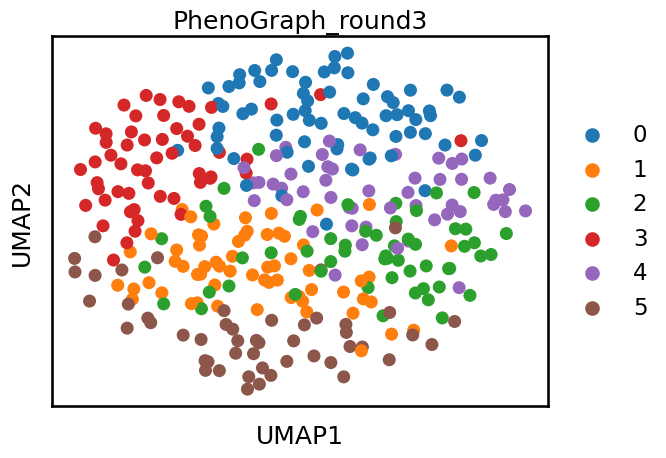

In [65]:
communities, graph, Q = sc.external.tl.phenograph(tcells_round3.obsm['X_scVI'], k = 30, resolution_parameter = 1.0)
tcells_round3.obs['PhenoGraph_round3'] = pd.Categorical(communities)
tcells_round3.uns['PhenoGraph_round3_Q'] = Q
sc.pl.umap(tcells_round3, color = 'PhenoGraph_round3')

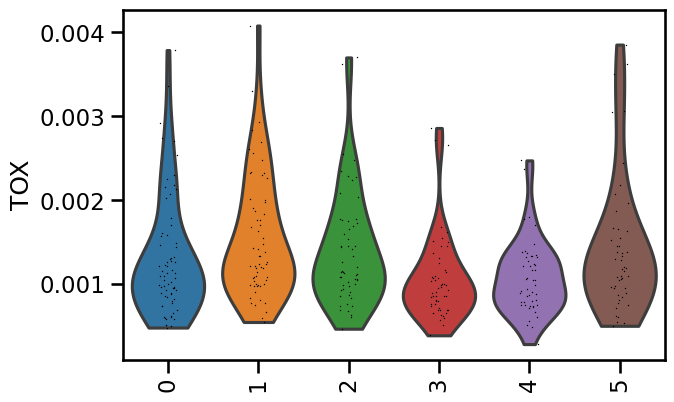

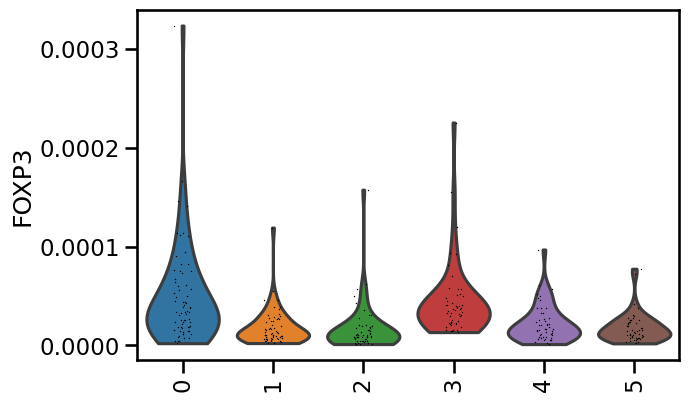

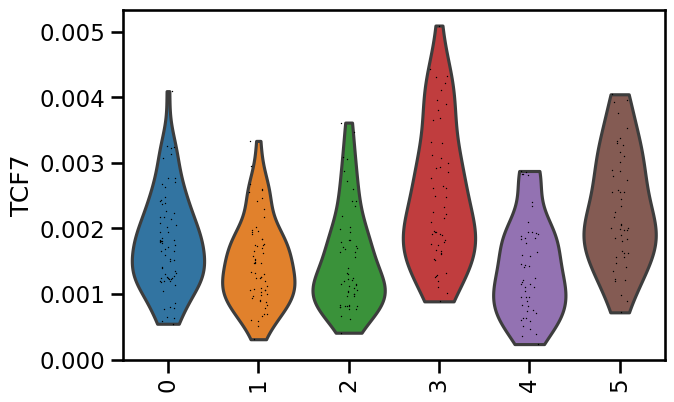

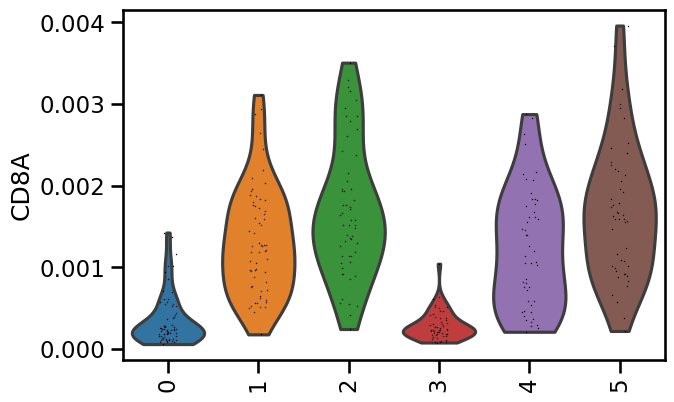

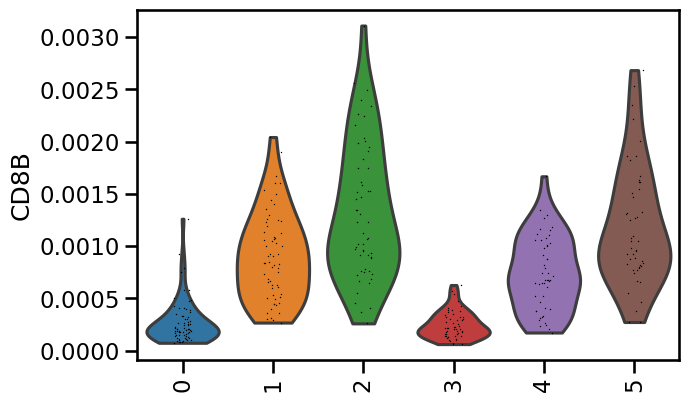

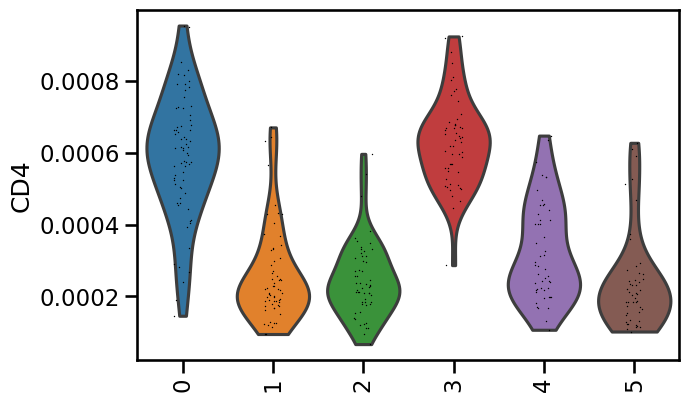

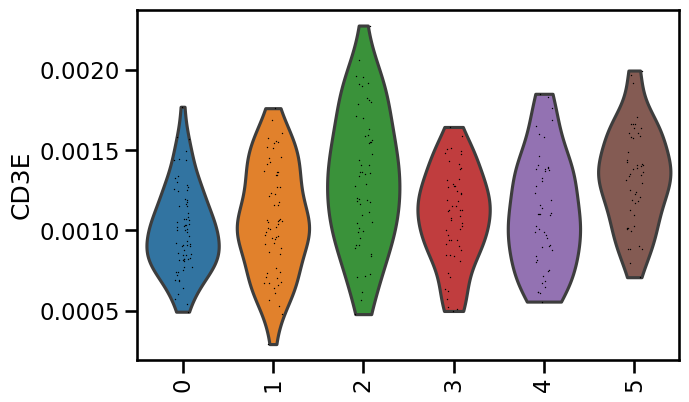

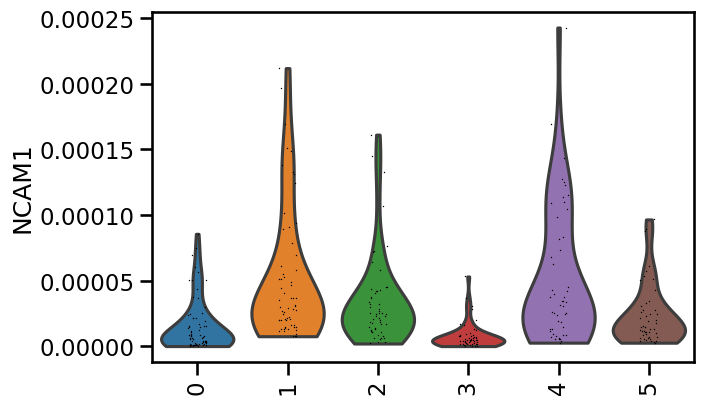

In [66]:
# violin plots of specific genes
violin_keys = ["TOX", "FOXP3", "TCF7", "CD8A", "CD8B", "CD4", "CD3E", "NCAM1"]
for key in violin_keys:
    sc.pl.violin(tcells_round3, layer = "scvi_normalized", use_raw = False, keys=key, 
                 groupby='PhenoGraph_round3', rotation=90)

In [67]:
tcells_round3.uns["log1p"]["base"] = None # needed if loading anndata (r/w error in scanpy)

# generate DEG tables using unintegrated, logarithmized counts and scanpy methods
sc.tl.rank_genes_groups(tcells_round3, 
                        groupby='PhenoGraph_round3',
                        # layer = "scvi_normalized",
                        use_raw = True,
                        method='t-test', 
                        key_added = "t-test_r3")
deg_df = sc.get.rank_genes_groups_df(tcells_round3, group=None, key='t-test_r3').sort_values(["scores"],ascending=False)

In [68]:
deg_df = deg_df.loc[(deg_df.pvals_adj < 0.05) & (deg_df.logfoldchanges > 1.0),:]
deg_df#.loc[deg_df.group=='3',:]#.names.values # IL2RA suggests Treg; directional FOXP3

group       names    scores  logfoldchanges         pvals  pvals_adj
107373     3       TXNIP  6.108710        1.341665  5.453173e-08   0.000070
107374     3       TSHZ2  5.996433        2.752782  1.265466e-07   0.000146
71582      2        CD8B  5.853566        1.540764  1.280845e-07   0.000764
107375     3        FHIT  5.825309        1.773744  1.708544e-07   0.000180
35791      1       PDE3B  5.723060        1.016636  1.158541e-07   0.000829
35792      1       NELL2  5.360459        1.092891  5.900894e-07   0.002669
107376     3      INPP4B  4.998002        1.322305  4.411942e-06   0.001698
35793      1      ATP8A1  4.750727        1.069435  7.896079e-06   0.021739
107378     3       IL6ST  4.687229        1.419917  1.591800e-05   0.004210
35794      1       NRCAM  4.578298        2.012727  1.876625e-05   0.035351
178956     5        AOAH  4.487406        2.108834  3.936204e-05   0.015829
143164     4         VIM  4.442202        1.269581  3.819048e-05   0.037517
107380     3        ANK3  4.441341        1.185960  3.262676e-05   0.006992
107382     3       PLCL1  4.177454        1.530891  9.205892e-05   0.013961
107383     3      ARID5B  3.932806        1.858256  2.273143e-04   0.025171
107384     3       FKBP5  3.880226        1.135971  2.425232e-04   0.026224
107385     3  CSGALNACT1  3.764361        1.160703  3.571373e-04   0.033995

In [69]:
# assign cell types based on clusters (round 3)
cluster_names_r3 = {
    0: "Naive CD4+ T", 
    1: "Naive CD8+ T",
    2: "Naive CD8+ T", 
    3: "Naive CD4+ T", 
    4: "Naive CD8+ T", 
    5: "Naive CD8+ T", 
}
tcells_round3.obs["cell_type_r3_khh"] = tcells_round3.obs['PhenoGraph_round3'].map(cluster_names_r3)

In [70]:
tcells.obs['cell_type_r3_khh'] = tcells_round3.obs['cell_type_r3_khh'] # add labels from round 3
tcells.obs['cell_type_khh'] = np.where(tcells.obs['cell_type_khh'] == 'TBD', # transfer labels from round 3
                                       tcells.obs['cell_type_r3_khh'], tcells.obs['cell_type_khh'])

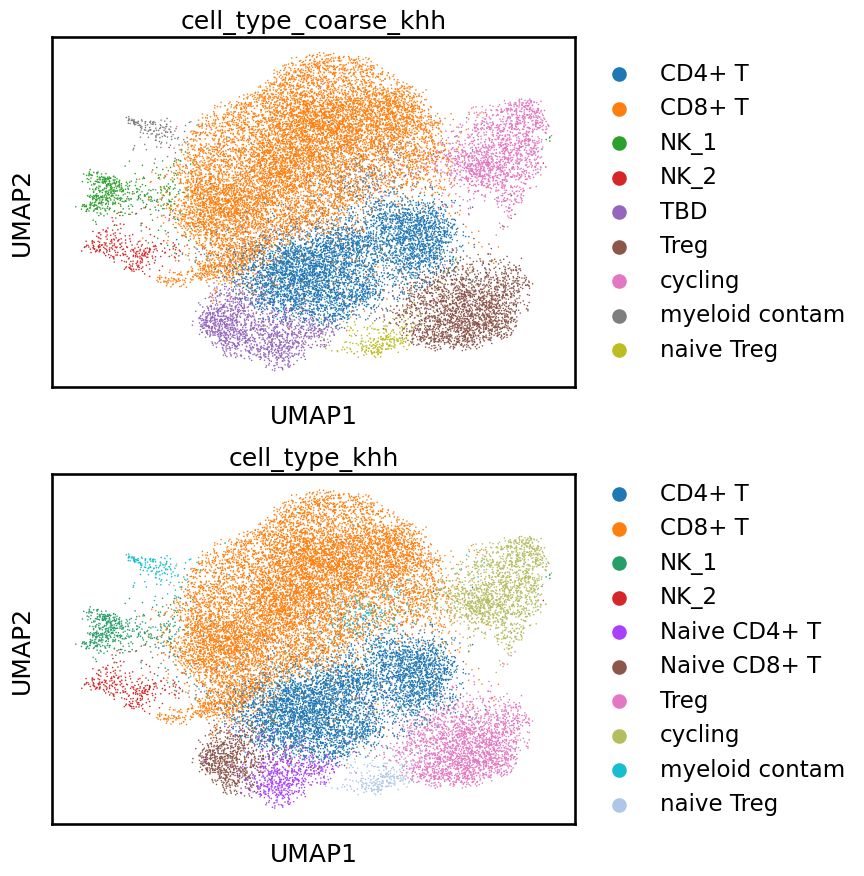

In [75]:
sc.pl.umap(tcells, color = ['cell_type_coarse_khh','cell_type_khh'], ncols = 1,)

In [76]:
# save file
tcells.write("tcells_scvi_annotated_041023.h5ad") #, compression="gzip") # save scVI output anndata file